Let's search the [Coastwatch ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/index.html) for datasets that contain the following information:

```
sanctsound "Sound Production"
```

In [1]:
import erddapy

erddapy.__version__

'2.0.1'

In [2]:
from erddapy import ERDDAP
import pandas as pd

server = "https://coastwatch.pfeg.noaa.gov/erddap/"

protocol = "griddap"

search_for = 'sanctsound "Sound Production"'

e = ERDDAP(server=server, protocol=protocol)

url = e.get_search_url(search_for=search_for, response="csv")

datasets = pd.read_csv(url)[["Dataset ID","Title"]]

datasets

,Dataset ID,Title
0,noaaSanctSound_GR01_01_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
1,noaaSanctSound_GR01_02_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
2,noaaSanctSound_GR01_03_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
3,noaaSanctSound_GR01_04_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
4,noaaSanctSound_GR01_05_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
...,...,...
690,noaaSanctSound_SB03_08_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
691,noaaSanctSound_SB03_09_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
692,noaaSanctSound_SB03_10_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
693,noaaSanctSound_SB03_11_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...


WoRMS lookup (which we don't need because Abby created a mapping table which we will use below)

In [3]:
# import pyworms

# title_piece = datasets.Title.str.split(",",expand=True)

# # pull out animal info from title

# title_unique = title_piece[1].str.replace(" Sound Production","").str.replace(" Sound Producion","").unique()

# animals = title_unique.tolist()

# animals_clean = []

# for animal in animals:
    
#     clean_str = animal.lstrip().lower()
    
#     animals_clean.append(clean_str)
    
#     print('Searching WoRMS for {}\n'.format(clean_str))
    
#     match = pyworms.aphiaRecordsByMatchNames(clean_str)
    
#     if match[0]:
#         print('Found {}:\n{}\n'.format(clean_str,match))
#     else:
#         print('{} not found\n'.format(clean_str))

Looks like we need to create a lookup table ourselves!

term | WoRMS Map 
-----|------
`dolphin` |
`blue whale` |
`bocaccio` |
`fin whale` |
`pinniped` |
`red grouper` |
`sei whale` |
`atlantic cod` |
`black grouper` |
`humpback whale` |
`killer whale` |
`minke whale` |
`plainfin midshipman` |
`north atlantic right whale` |

Instead of searching WoRMS, we will use the mapping table Abby created.

In [4]:
import pandas as pd

df_mapping = pd.read_csv('SanctSound_SpeciesLookupTable.csv')

df_mapping

,vernacularName,scientificName,scientificNameID,taxonRank,kingdom
0,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia
2,bocaccio,Sebastes paucispinis,urn:lsid:marinespecies.org:taxname:274833,Species,Animalia
3,fin whale,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
4,pinniped,Pinnipedia,urn:lsid:marinespecies.org:taxname:148736),Infraorder,Animalia
5,red grouper,Epinephelus morio,urn:lsid:marinespecies.org:taxname:159354,Species,Animalia
6,sei whale,Balaenoptera borealis,urn:lsid:marinespecies.org:taxname:137088,Species,Animalia
7,atlantic cod,Gadus morhua,urn:lsid:marinespecies.org:taxname:126436,Species,Animalia
8,black grouper,Mycteroperca bonaci,urn:lsid:marinespecies.org:taxname:159231,Species,Animalia
9,humpback whale,Megaptera novaeangliae,urn:lsid:marinespecies.org:taxname:137092,Species,Animalia


# Next let's do it for all of them.

Now lets find the `start_time` and `end_time` when dolphins were present in this dataset (`dolphin_presence == 1`).

To do this we look through the variables in the dataset to find the data variable which ends with the phrase `presence`. This will return the string of the variable name `dolphin_presence`. Then, we want to filter the dataset for when that variable has values equal to 1.0 (or present). Then, we drop any entrys not equal to 1.0.

This returns a filtered xarray dataset of only presence values along with `start_time`, `end_time`, and all the associated metadata.

We can now start porting that information into the DarwinCore format as a Pandas DataFrame.

Now we can add in the information from our WoRMS mapping above.

In [13]:
%%time

e.response = "nc"

df_final = pd.DataFrame()

df_broken = pd.DataFrame()

for index, row in datasets.iterrows():
    
    print('\n{}/{} datasets\n'.format(index+1,datasets.shape[0]))
    print('querying {}'.format(row['Dataset ID']))
    
    e.dataset_id = row['Dataset ID']
    
    # set up try/except to skip datasets that we cant pull into xarray - issues with configuration
    ds = e.to_xarray()
#     try:
#         ds = e.to_xarray()
#     except:
#         print('Skipping {} - url not functioning'.format(row['Dataset ID']))
#         continue
    
    time_var = list(ds.coords)[0]
    
    print('{} ({} rows): {}'.format(row['Dataset ID'],ds.coords.dims[time_var],ds.geospatial_bounds))
    
    # set up try/except to test for presence vars, skip datasets without them.
    try:
        da = [da for varname, da in ds.data_vars.items() if varname.endswith("presence")][0]
    except:
        
        string = 'Skipping {} - no presence vars'.format(row['Dataset ID'])
        
        df_broke = pd.DataFrame({'Dataset ID': [row['Dataset ID']], 
                                'reason': [string]})
        df_broken = pd.concat([df_broken, df_broke])
        
        #print(string)
        continue

    
    # subset to only presences (presence var == 1)
    ds_subset = da[da.values == 1]
    
    # kick out if ds_subset is empty
    if len(ds_subset[time_var]) == 0:
        
        string = '{} obs - moving to next dataset'.format(len(ds_subset[time_var]))
        
        df_broke = pd.DataFrame({'Dataset ID': [row['Dataset ID']], 
                                'reason': [string]})
        
        df_broken = pd.concat([df_broken, df_broke])
        
        #print(string)
        continue
        
    df = ds_subset.to_dataframe().reset_index()
    
    print('Subsetted to ({} rows)'.format(len(ds_subset[time_var])))
    
    df['dataset_id'] = row['Dataset ID']

    df['WKT'] = ds.geospatial_bounds

    df['decimalLatitude'] = ds.geospatial_bounds.split(" ")[1].replace("(","")

    df['decimalLongitude'] = ds.geospatial_bounds.split(" ")[2].replace(")","")

    df['vernacularName'] = ds.title.split(",")[1].replace(" Sound Production","").replace(" Sound Producion","").lower().lstrip()
    
    df_final = pd.concat([df_final, df])

# write to csv file
#df_occur.to_csv('data/sanctsound_presence.csv', index=False)
df_broken


1/695 datasets

querying noaaSanctSound_GR01_01_dolphins_1h
Subsetted to (191 rows)

2/695 datasets

querying noaaSanctSound_GR01_02_dolphins_1h
Subsetted to (56 rows)

3/695 datasets

querying noaaSanctSound_GR01_03_dolphins_1h
Subsetted to (146 rows)

4/695 datasets

querying noaaSanctSound_GR01_04_dolphins_1h
Subsetted to (110 rows)

5/695 datasets

querying noaaSanctSound_GR01_05_dolphins_1h
Subsetted to (341 rows)

6/695 datasets

querying noaaSanctSound_GR02_02_dolphins_1h
Subsetted to (291 rows)

7/695 datasets

querying noaaSanctSound_GR02_03_dolphins_1h
Subsetted to (339 rows)

8/695 datasets

querying noaaSanctSound_GR02_05_dolphins_1h
Subsetted to (752 rows)

9/695 datasets

querying noaaSanctSound_GR03_02_dolphins_1h
Subsetted to (172 rows)

10/695 datasets

querying noaaSanctSound_GR03_03_dolphins_1h
Subsetted to (101 rows)

11/695 datasets

querying noaaSanctSound_GR03_04_dolphins_1h
Subsetted to (499 rows)

12/695 datasets

querying noaaSanctSound_GR03_05_dolphins_1h
Su


108/695 datasets

querying noaaSanctSound_SB02_06_bluewhale_1d
Subsetted to (7 rows)

109/695 datasets

querying noaaSanctSound_SB02_07_bluewhale_1d

110/695 datasets

querying noaaSanctSound_SB02_08_bluewhale_1d

111/695 datasets

querying noaaSanctSound_SB02_09_bluewhale_1d

112/695 datasets

querying noaaSanctSound_SB02_10_bluewhale_1d

113/695 datasets

querying noaaSanctSound_SB02_11_bluewhale_1d

114/695 datasets

querying noaaSanctSound_SB02_12_bluewhale_1d

115/695 datasets

querying noaaSanctSound_SB03_01_bluewhale_1d

116/695 datasets

querying noaaSanctSound_SB03_02_bluewhale_1d

117/695 datasets

querying noaaSanctSound_SB03_03_bluewhale_1d

118/695 datasets

querying noaaSanctSound_SB03_04_bluewhale_1d

119/695 datasets

querying noaaSanctSound_SB03_05_bluewhale_1d

120/695 datasets

querying noaaSanctSound_SB03_06_bluewhale_1d
Subsetted to (4 rows)

121/695 datasets

querying noaaSanctSound_SB03_07_bluewhale_1d

122/695 datasets

querying noaaSanctSound_SB03_08_bluewhale

Subsetted to (401 rows)

208/695 datasets

querying noaaSanctSound_SB02_05_dolphins_1h
Subsetted to (238 rows)

209/695 datasets

querying noaaSanctSound_SB02_06_dolphins_1h
Subsetted to (223 rows)

210/695 datasets

querying noaaSanctSound_SB02_07_dolphins_1h
Subsetted to (202 rows)

211/695 datasets

querying noaaSanctSound_SB02_08_dolphins_1h
Subsetted to (225 rows)

212/695 datasets

querying noaaSanctSound_SB02_09_dolphins_1h
Subsetted to (655 rows)

213/695 datasets

querying noaaSanctSound_SB02_10_dolphins_1h
Subsetted to (73 rows)

214/695 datasets

querying noaaSanctSound_SB02_11_dolphins_1h
Subsetted to (166 rows)

215/695 datasets

querying noaaSanctSound_SB02_12_dolphins_1h
Subsetted to (329 rows)

216/695 datasets

querying noaaSanctSound_SB02_13_dolphins_1h
Subsetted to (359 rows)

217/695 datasets

querying noaaSanctSound_SB02_14_dolphins_1h
Subsetted to (163 rows)

218/695 datasets

querying noaaSanctSound_SB02_15_dolphins_1h
Subsetted to (894 rows)

219/695 datasets

q

Subsetted to (53 rows)

312/695 datasets

querying noaaSanctSound_CI02_05_pinnipeds
Subsetted to (134 rows)

313/695 datasets

querying noaaSanctSound_CI02_06_pinnipeds
Subsetted to (7 rows)

314/695 datasets

querying noaaSanctSound_CI02_07_pinnipeds
Subsetted to (30 rows)

315/695 datasets

querying noaaSanctSound_FK01_01_redgrouper_1min

316/695 datasets

querying noaaSanctSound_FK01_01_seiwhale_1d

317/695 datasets

querying noaaSanctSound_FK02_01_seiwhale_1d

318/695 datasets

querying noaaSanctSound_FK03_01_seiwhale_1d

319/695 datasets

querying noaaSanctSound_GR01_01_seiwhale_1d

320/695 datasets

querying noaaSanctSound_GR01_02_seiwhale_1d

321/695 datasets

querying noaaSanctSound_GR02_02_seiwhale_1d

322/695 datasets

querying noaaSanctSound_GR03_02_seiwhale_1d

323/695 datasets

querying noaaSanctSound_SB01_01_seiwhale_1d

324/695 datasets

querying noaaSanctSound_SB01_02_seiwhale_1d
Subsetted to (13 rows)

325/695 datasets

querying noaaSanctSound_SB01_03_seiwhale_1d
Subse

Subsetted to (112 rows)

414/695 datasets

querying noaaSanctSound_CI04_05_humpbackwhale_1d
Subsetted to (82 rows)

415/695 datasets

querying noaaSanctSound_CI04_06_humpbackwhale_1d
Subsetted to (109 rows)

416/695 datasets

querying noaaSanctSound_CI04_07_humpbackwhale_1d
Subsetted to (86 rows)

417/695 datasets

querying noaaSanctSound_CI04_08_humpbackwhale_1d
Subsetted to (77 rows)

418/695 datasets

querying noaaSanctSound_CI05_01_humpbackwhale_1d
Subsetted to (65 rows)

419/695 datasets

querying noaaSanctSound_CI05_02_humpbackwhale_1d
Subsetted to (55 rows)

420/695 datasets

querying noaaSanctSound_CI05_03_humpbackwhale_1d
Subsetted to (15 rows)

421/695 datasets

querying noaaSanctSound_CI05_04_humpbackwhale_1d
Subsetted to (78 rows)

422/695 datasets

querying noaaSanctSound_CI05_05_humpbackwhale_1d
Subsetted to (2 rows)

423/695 datasets

querying noaaSanctSound_CI05_06_humpbackwhale_1d
Subsetted to (67 rows)

424/695 datasets

querying noaaSanctSound_CI05_08_humpbackwhale_1

Subsetted to (59 rows)

507/695 datasets

querying noaaSanctSound_OC01_01_killerwhale
Subsetted to (18 rows)

508/695 datasets

querying noaaSanctSound_OC01_03_killerwhale
Subsetted to (140 rows)

509/695 datasets

querying noaaSanctSound_OC02_01_killerwhale
Subsetted to (11 rows)

510/695 datasets

querying noaaSanctSound_OC02_02_killerwhale
Subsetted to (180 rows)

511/695 datasets

querying noaaSanctSound_OC02_04_killerwhale
Subsetted to (78 rows)

512/695 datasets

querying noaaSanctSound_OC02_05_killerwhale
Subsetted to (109 rows)

513/695 datasets

querying noaaSanctSound_OC03_02_killerwhale
Subsetted to (13 rows)

514/695 datasets

querying noaaSanctSound_OC03_03_killerwhale
Subsetted to (7 rows)

515/695 datasets

querying noaaSanctSound_OC03_04_killerwhale
Subsetted to (25 rows)

516/695 datasets

querying noaaSanctSound_OC04_02_killerwhale
Subsetted to (4 rows)

517/695 datasets

querying noaaSanctSound_OC04_04_killerwhale
Subsetted to (22 rows)

518/695 datasets

querying no

Subsetted to (44 rows)

605/695 datasets

querying noaaSanctSound_MB02_04_plainfinmidshipman
Subsetted to (8 rows)

606/695 datasets

querying noaaSanctSound_MB02_05_plainfinmidshipman
Subsetted to (102 rows)

607/695 datasets

querying noaaSanctSound_MB02_07_plainfinmidshipman

608/695 datasets

querying noaaSanctSound_FK01_01_northatlanticrightwhale_1d

609/695 datasets

querying noaaSanctSound_FK02_01_northatlanticrightwhale_1d

610/695 datasets

querying noaaSanctSound_FK03_01_northatlanticrightwhale_1d

611/695 datasets

querying noaaSanctSound_GR01_01_northatlanticrightwhale_1d
Subsetted to (3 rows)

612/695 datasets

querying noaaSanctSound_GR01_02_northatlanticrightwhale_1d

613/695 datasets

querying noaaSanctSound_GR01_03_northatlanticrightwhale_1d
Subsetted to (2 rows)

614/695 datasets

querying noaaSanctSound_GR01_04_northatlanticrightwhale_1d

615/695 datasets

querying noaaSanctSound_GR01_05_northatlanticrightwhale_1d
Subsetted to (9 rows)

616/695 datasets

querying noa

,Dataset ID,reason
0,noaaSanctSound_CI01_03_bluewhale,0 obs - moving to next dataset
0,noaaSanctSound_CI01_04_bluewhale_manual,0 obs - moving to next dataset
0,noaaSanctSound_CI01_07_bluewhale_manual,0 obs - moving to next dataset
0,noaaSanctSound_CI01_08_bluewhale_manual,0 obs - moving to next dataset
0,noaaSanctSound_CI02_04_bluewhale_manual,0 obs - moving to next dataset
...,...,...
0,noaaSanctSound_GR03_02_finwhale_1d,0 obs - moving to next dataset
0,noaaSanctSound_FK01_01_finwhale_1d,0 obs - moving to next dataset
0,noaaSanctSound_FK02_01_finwhale_1d,0 obs - moving to next dataset
0,noaaSanctSound_FK03_01_finwhale_1d,0 obs - moving to next dataset


In [39]:
# print(df_broken.to_html(notebook=True))

datasets with issues/no obs:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Dataset ID</th>
      <th>reason</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_03_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_04_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_07_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_08_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI02_04_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_02_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_03_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI04_04_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_04_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_05_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_07_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK01_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK02_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK03_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_02_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR02_02_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR03_02_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB02_02_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB03_01_disk3_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB03_01_disk4_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC01_01_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC01_03_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC02_01_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC02_04_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC02_05_bluewhale_manual</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC03_04_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC04_02_bluewhale</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_02_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_03_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_04_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_05_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_06_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_07_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_08_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_09_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_10_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_11_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_12_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_02_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_03_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_04_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_05_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_07_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_08_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_09_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_10_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_11_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_12_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_01_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_02_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_03_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_04_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_05_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_07_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_08_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_09_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_10_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_11_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_12_bluewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_03_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_04_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_05_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_06_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_07_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_08_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI02_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_03_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_04_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_05_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI03_06_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_05_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB01_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB02_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB02_08_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB02_09_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB03_03_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC01_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC01_03_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC02_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC02_04_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC02_05_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC03_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC03_03_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC03_04_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC04_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_OC04_04_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_04_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK01_01_redgrouper_1min</td>
      <td>Skipping noaaSanctSound_FK01_01_redgrouper_1mi...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK01_01_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK02_01_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK03_01_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_01_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_02_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR02_02_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR03_02_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_01_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_04_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_07_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_10_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_11_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_01_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_07_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_07_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_11_seiwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_03_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_14_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_03_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_14_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_03_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_08_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_13_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_14_atlanticcod</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK01_01_blackgrouper_1min</td>
      <td>Skipping noaaSanctSound_FK01_01_blackgrouper_1...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI01_08_humpbackwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_01_humpbackwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_02_humpbackwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI01_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI01_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI01_02_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI01_02_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI01_03_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI01_03_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI03_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI03_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI03_02_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI03_02_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI03_03_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI03_03_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI04_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI04_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI04_02_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI04_02_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI04_03_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI04_03_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI05_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI05_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI06_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI06_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_HI06_02_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_HI06_02_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_02_minkewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_07_minkewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_14_minkewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_14_minkewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_07_minkewhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM01_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM01_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM01_02_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM01_02_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM02_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM02_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM02_02_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM02_02_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM05_01_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM05_01_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM08_12_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM08_12_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_PM08_13_GoogleAI_humpbackwhale_1h</td>
      <td>Skipping noaaSanctSound_PM08_13_GoogleAI_humpb...</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI02_01_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI02_02_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI04_01_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI04_02_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI04_03_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_01_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_02_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_CI05_03_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB01_01_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB01_03_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB01_04_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB01_09_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB02_01_sonar</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_MB02_07_plainfinmidshipman</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK01_01_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK02_01_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK03_01_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_02_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_04_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR02_02_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR03_02_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_01_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_03_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_04_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_05_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_06_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_11_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_12_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_04_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_06_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_10_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB02_11_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_11_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB03_12_northatlanticrightwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR01_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR02_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_GR03_02_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK01_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK02_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_FK03_01_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
    <tr>
      <th>0</th>
      <td>noaaSanctSound_SB01_10_finwhale_1d</td>
      <td>0 obs - moving to next dataset</td>
    </tr>
  </tbody>
</table>
</div>

Now lets add in the WoRMS mapping for species information.

In [15]:
# merge in the WoRMS species information
df_occur = df_final.merge(df_mapping, how='left', on='vernacularName')  

# overwrite to csv file
fname = 'data/sanctsound_presence.zip'
df_occur.to_csv(fname, index=False, compression='zip')

df_occur

,start_time,dolphin_presence,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_presence,bluewhale_manual_presence,...,atlanticcod_presence,humpbackwhale_presence,killerwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom
0,2018-12-15 04:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,2018-12-15 05:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2,2018-12-15 06:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
3,2018-12-15 07:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
4,2018-12-15 18:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712299,2020-11-18 00:00:00,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
712300,2020-11-19 00:00:00,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
712301,2020-11-20 00:00:00,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
712302,2020-11-21 00:00:00,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia


In [16]:
df_occur.dtypes.values

array([dtype('<M8[ns]'), dtype('float64'), dtype('O'), dtype('O'),
       dtype('O'), dtype('O'), dtype('O'), dtype('<M8[ns]'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'),
       dtype('O'), dtype('O'), dtype('O')], dtype=object)

---
# Creating occurrence file

Read in the datafile we just created.

In [17]:
import pandas as pd
import numpy as np

df_occur = pd.read_csv(fname,dtype = df_occur.dtypes.values, compression='zip')

Make a plot, just to check the data.

In [18]:
# cols = [col for col in df_occur.columns if 'presence' in col]

# df_occur[cols].plot()

In [19]:
df_occur.columns

Index(['start_time', 'dolphin_presence', 'dataset_id', 'WKT',
       'decimalLatitude', 'decimalLongitude', 'vernacularName', 'time',
       'bluewhale_presence', 'bluewhale_manual_presence', 'bocaccio_presence',
       'finwhale_presence', 'pinniped_presence', 'seiwhale_presence',
       'atlanticcod_presence', 'humpbackwhale_presence',
       'killerwhale_presence', 'minkewhale_presence',
       'plainfinmidshipman_presence', 'northatlanticrightwhale_presence',
       'scientificName', 'scientificNameID', 'taxonRank', 'kingdom'],
      dtype='object')

Okay, we have three time variables: 
`start_time`, `end_time`, `time`

We need to make one `eventDate`!

Let's first check to see if we can mash things together.

First, lets print out all the times when `time` has an entry:

In [20]:
df_occur.loc[df_occur['time'].notna(),['start_time','time']]

,start_time,time
3447,NaN,2018-11-07 22:02:01.456000000
3448,NaN,2018-11-15 15:18:02.648000000
3449,NaN,2018-11-15 15:18:55.896000256
3450,NaN,2018-11-15 15:19:49.144000000
3451,NaN,2018-11-15 15:22:30.936000000
...,...,...
602841,NaN,2020-12-21 17:04:17.500000000
602842,NaN,2020-12-21 21:55:15.500000000
602843,NaN,2020-12-21 22:20:10.500000000
602844,NaN,2020-12-21 23:32:10.500000000


Okay, so let's see if `start_time` is only NaN for all those rows:

In [21]:
df_occur.loc[df_occur['time'].notna(),'start_time'].unique()

array([nan], dtype=object)

Looking good!

Fantastic! So, this means we can make a new column for `eventDate` which merges `time` into `start_time` (or `end_time`?)

In [22]:
df_occur_copy = df_occur.copy()

# start eventDate column with values where `time` exists.
df_occur_copy['eventDate'] = df_occur_copy.loc[df_occur_copy['time'].notna(),['time']]

# fillna with values from start_time
df_occur_copy['eventDate'].fillna(df_occur_copy['start_time'], inplace=True)

df_occur_copy

,start_time,dolphin_presence,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_presence,bluewhale_manual_presence,...,humpbackwhale_presence,killerwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom,eventDate
0,2018-12-15 04:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 04:00:00
1,2018-12-15 05:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 05:00:00
2,2018-12-15 06:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 06:00:00
3,2018-12-15 07:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 07:00:00
4,2018-12-15 18:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712299,2020-11-18 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-18 00:00:00.000000000
712300,2020-11-19 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-19 00:00:00.000000000
712301,2020-11-20 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-20 00:00:00.000000000
712302,2020-11-21 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-21 00:00:00.000000000


In [23]:
df_occur_copy.loc[df_occur_copy['time'].isna(),['start_time','eventDate','time']]

,start_time,eventDate,time
0,2018-12-15 04:00:00,2018-12-15 04:00:00,NaN
1,2018-12-15 05:00:00,2018-12-15 05:00:00,NaN
2,2018-12-15 06:00:00,2018-12-15 06:00:00,NaN
3,2018-12-15 07:00:00,2018-12-15 07:00:00,NaN
4,2018-12-15 18:00:00,2018-12-15 18:00:00,NaN
...,...,...,...
712299,2020-11-18 00:00:00.000000000,2020-11-18 00:00:00.000000000,NaN
712300,2020-11-19 00:00:00.000000000,2020-11-19 00:00:00.000000000,NaN
712301,2020-11-20 00:00:00.000000000,2020-11-20 00:00:00.000000000,NaN
712302,2020-11-21 00:00:00.000000000,2020-11-21 00:00:00.000000000,NaN


Now, lets make `eventDate` the index for our DataFrame so we can make a nice plot and output the dates in a format we like.

In [24]:
df_occur_copy['eventDate'] = pd.to_datetime(df_occur_copy['eventDate'], format='%Y-%m-%d %H:%M:%S.%f')

df_occur_copy

,start_time,dolphin_presence,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_presence,bluewhale_manual_presence,...,humpbackwhale_presence,killerwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom,eventDate
0,2018-12-15 04:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 04:00:00
1,2018-12-15 05:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 05:00:00
2,2018-12-15 06:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 06:00:00
3,2018-12-15 07:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 07:00:00
4,2018-12-15 18:00:00,1.0,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712299,2020-11-18 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-18 00:00:00
712300,2020-11-19 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-19 00:00:00
712301,2020-11-20 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-20 00:00:00
712302,2020-11-21 00:00:00.000000000,NaN,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-21 00:00:00


Let's pull out the presence columns and make a quick plot to see if the values are what we were expecting (value of 1).

In [25]:
cols = [col for col in df_occur_copy.columns if 'presence' in col]

#df_occur_copy[cols].plot()

Let's do some checking to make sure we're doing what we think. Below, we will find where a presence value equals 1, and see if we return a unique `scientificNameID`.

In [26]:
for column in cols:
    if len(df_occur_copy.loc[df_occur_copy[column]=='1.0','scientificNameID'].unique()) != 1:
        print('{} != 1'.format(column))
    else:
        print('{} is good!'.format(column))

dolphin_presence is good!
bluewhale_presence is good!
bluewhale_manual_presence is good!
bocaccio_presence is good!
finwhale_presence is good!
pinniped_presence is good!
seiwhale_presence is good!
atlanticcod_presence is good!
humpbackwhale_presence is good!
killerwhale_presence is good!
minkewhale_presence is good!
plainfinmidshipman_presence is good!
northatlanticrightwhale_presence is good!


Now, let's make sure we don't have any NaN rows for the presence columns. Here we check all the **presence** columns for when an entire row contains NaN. If we did our munging correctly this should return all `False`. Meaning there were no rows where all presence columns contained NaNs. 

In [27]:
df_occur_copy['is_na'] = df_occur_copy[cols].isnull().apply(lambda x: all(x), axis=1) 

df_occur_copy['is_na'].unique()

array([False])

Let's make an appropriate `occurrenceID` by appending the `eventDate` to the `dataset_id`.

Second we want to check that all occurrences are unique using this method.

As shown below, some of the `occurrenceID`'s are duplicates. This looks like it's because the time elements record down to the fraction of a second (eg. `2018-11-10 03:28:10.584000000`, when we translated this to **ISO 8601** we dropped the fraction of a second, which resulted in a duplicate `occurrenceID`. _(see the first two rows of the table below for an example)_

In [28]:
df_occur_copy['occurrenceID'] = df_occur_copy['dataset_id'] + "_" + df_occur_copy['eventDate'].dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

df_occur_copy.loc[df_occur_copy['occurrenceID'].duplicated(keep=False)]

,start_time,dolphin_presence,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_presence,bluewhale_manual_presence,...,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom,eventDate,is_na,occurrenceID


Now, that we know we are representing the precenses appropriately. Let's remove the columns we don't need for DwC. That information will be documented via the species information. The `finwhal_effort` column is recording something not consistant with `presence` so let's remove that column.

In [29]:
cols = [col for col in df_occur_copy.columns if 'presence' in col]

cols.extend(['is_na','time','start_time','dataset_id'])

occur = df_occur_copy.drop(columns=cols)

occur.sample(10)

,WKT,decimalLatitude,decimalLongitude,vernacularName,scientificName,scientificNameID,taxonRank,kingdom,eventDate,occurrenceID
229464,POINT (33.8489 -120.1171),33.8489,-120.1171,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-09-13 16:42:48.496000000,noaaSanctSound_CI04_05_bluewhale_2020-09-13T16...
28464,POINT (34.0853 -120.5223),34.0853,-120.5223,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-09-10 01:57:04.408000000,noaaSanctSound_CI02_05_bluewhale_2020-09-10T01...
527330,POINT (36.6484 -121.9075),36.6484,-121.9075,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-06-08 14:54:21.328000000,noaaSanctSound_MB02_05_bluewhale_2020-06-08T14...
306624,POINT (33.8485 -120.1159),33.8485,-120.1159,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2021-09-02 12:09:07.272000000,noaaSanctSound_CI04_08_bluewhale_2021-09-02T12...
566194,POINT (36.37021 -122.314903),36.37021,-122.314903,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-09-03 21:46:02.720000000,noaaSanctSound_MB03_03_bluewhale_2020-09-03T21...
409491,POINT (36.7977 -121.9757),36.7977,-121.9757,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-08-17 03:27:52.384000000,noaaSanctSound_MB01_05_bluewhale_2020-08-17T03...
653514,POINT (36.798 -121.976),36.798,-121.976,bocaccio,Sebastes paucispinis,urn:lsid:marinespecies.org:taxname:274833,Species,Animalia,2019-10-30 01:51:04.226000128,noaaSanctSound_MB01_03_bocaccio_2019-10-30T01:...
695219,POINT (42.25532 -70.178937),42.25532,-70.178937,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2020-12-02 07:00:00.000000000,noaaSanctSound_SB03_13_dolphins_1h_2020-12-02T...
522134,POINT (36.6495 -121.9084),36.6495,-121.9084,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2019-12-28 16:50:41.624000000,noaaSanctSound_MB02_04_bluewhale_2019-12-28T16...
406303,POINT (36.7977 -121.9757),36.7977,-121.9757,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-07-29 21:22:13.696000000,noaaSanctSound_MB01_05_bluewhale_2020-07-29T21...


Let's write it out as an occurrence file.

In [30]:
fname_occur = 'data/occurrence.zip'
occur.to_csv(fname_occur,date_format='%Y-%m-%dT%H:%M:%S.%fZ', index=False, compression='zip')

# Post-processing analysis

Let's read it back in to do some fiddling.

In [31]:
import pandas as pd

occur = pd.read_csv(fname_occur, low_memory=False, compression='zip')

occur.sample(5)

,WKT,decimalLatitude,decimalLongitude,vernacularName,scientificName,scientificNameID,taxonRank,kingdom,eventDate,occurrenceID
585647,POINT (36.37021 -122.314903),36.37021,-122.314903,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-11-07T13:37:09.216000Z,noaaSanctSound_MB03_04_bluewhale_2020-11-07T13...
226929,POINT (33.8489 -120.1171),33.84890,-120.117100,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2020-09-09T02:22:02.280000Z,noaaSanctSound_CI04_05_bluewhale_2020-09-09T02...
682907,POINT (42.43835 -70.54556),42.43835,-70.545560,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2021-06-24T04:00:00.000000Z,noaaSanctSound_SB01_16_dolphins_1h_2021-06-24T...
643758,POINT (36.798 -121.976),36.79800,-121.976000,bocaccio,Sebastes paucispinis,urn:lsid:marinespecies.org:taxname:274833,Species,Animalia,2019-01-19T11:47:54.048999Z,noaaSanctSound_MB01_01_bocaccio_2019-01-19T11:...
497571,POINT (36.798 -122.9758),36.79800,-122.975800,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia,2021-10-20T06:35:13.712000Z,noaaSanctSound_MB01_09_bluewhale_2021-10-20T06...


In [32]:
occur['occurrenceID'][50000]

'noaaSanctSound_CI02_05_bluewhale_2020-10-10T10:52:24.424000Z'

In [33]:
import humanize
import os

humanize.naturalsize(os.path.getsize('data/occurrence.zip'))

'6.4 MB'

In [34]:
humanize.naturalsize(os.path.getsize('data/sanctsound_presence.zip'))

'4.7 MB'

<AxesSubplot: xlabel='decimalLongitude', ylabel='decimalLatitude'>

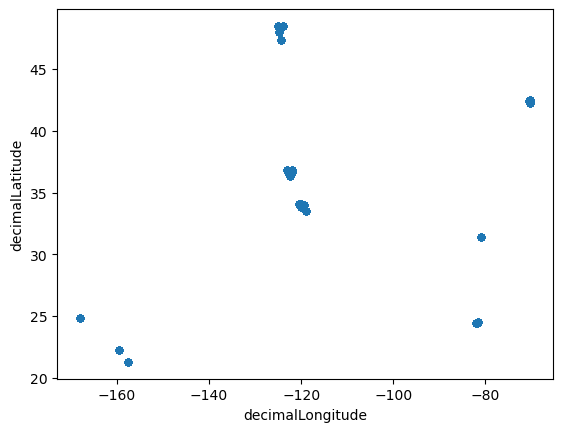

In [35]:
occur.plot.scatter(x='decimalLongitude',y='decimalLatitude')

In [36]:
import geopandas as gpd

  # read into geopandas dataframe for plotting
gdf = gpd.GeoDataFrame(
    occur, 
    geometry=gpd.points_from_xy(occur.decimalLongitude, occur.decimalLatitude),
    crs = "epsg:4326",
    )

gdf

,WKT,decimalLatitude,decimalLongitude,vernacularName,scientificName,scientificNameID,taxonRank,kingdom,eventDate,occurrenceID,geometry
0,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15T04:00:00.000000Z,noaaSanctSound_GR01_01_dolphins_1h_2018-12-15T...,POINT (-80.89040 31.39642)
1,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15T05:00:00.000000Z,noaaSanctSound_GR01_01_dolphins_1h_2018-12-15T...,POINT (-80.89040 31.39642)
2,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15T06:00:00.000000Z,noaaSanctSound_GR01_01_dolphins_1h_2018-12-15T...,POINT (-80.89040 31.39642)
3,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15T07:00:00.000000Z,noaaSanctSound_GR01_01_dolphins_1h_2018-12-15T...,POINT (-80.89040 31.39642)
4,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15T18:00:00.000000Z,noaaSanctSound_GR01_01_dolphins_1h_2018-12-15T...,POINT (-80.89040 31.39642)
...,...,...,...,...,...,...,...,...,...,...,...
712299,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-18T00:00:00.000000Z,noaaSanctSound_SB03_12_finwhale_1d_2020-11-18T...,POINT (-70.17905 42.25508)
712300,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-19T00:00:00.000000Z,noaaSanctSound_SB03_12_finwhale_1d_2020-11-19T...,POINT (-70.17905 42.25508)
712301,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-20T00:00:00.000000Z,noaaSanctSound_SB03_12_finwhale_1d_2020-11-20T...,POINT (-70.17905 42.25508)
712302,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-21T00:00:00.000000Z,noaaSanctSound_SB03_12_finwhale_1d_2020-11-21T...,POINT (-70.17905 42.25508)


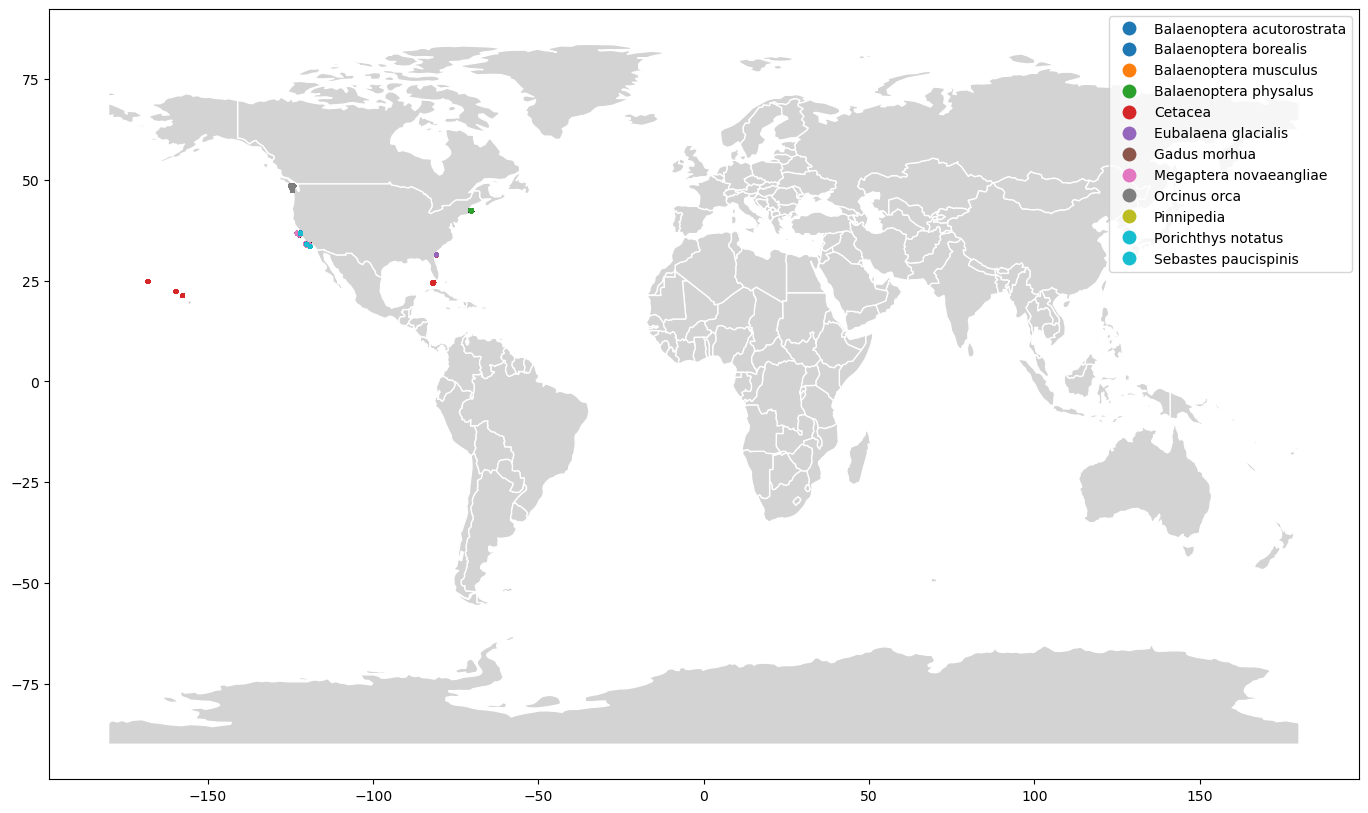

In [37]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(20,10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.to_crs(gdf.crs)

world.plot(ax=ax, color='lightgrey', edgecolor='white')

gdf.plot(ax=ax, markersize=5, column='scientificName', legend=True)

plt.show()

Let's explore these data a little bit. But first, lets find the unique locations where each species is found, then we can explore those results.

In [38]:
gdf_unique = gdf.drop_duplicates(subset=["geometry", "scientificNameID",'WKT'], keep='first')

gdf_unique.explore(column='vernacularName',tooltip=True, popup=True, tiles='CartoDB positron')